# Building a greedy k-Armed Bandit

* We have an **agent** which we allow to choose **actions**, and each action has a reward that is returned according to a given, underlying **probability distribution**. 
* The game is played over many **episodes** (single actions in this case) and the goal is to maximize your reward.

In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext nb_black

<IPython.core.display.Javascript object>

* going to iteratively build a model that will converge towards the true value of each action. 
* using a Gaussian (normal) distribution for all of the underlying probability distributions that we’ll explore so that the mean corresponds to the true value (after all, given enough samples, we would expect our rewards to converge to the mean of the selected action).
* need to figure out an algorithm that explores enough of our search space so that we can exploit the best actions.


## $\epsilon$ Greedy Bandit
1. class `eps_bandit`
2. number of arms `k`
3. $\epsilon$ value or probability to explore other values `eps`
4. number of iterations `iter`
5. adjust average rewards of each arm `mu` 

In [2]:
class eps_bandit:
    """
    epsilon-greedy k-bandit problem

    Inputs
    =====================================================
    k: number of arms (int)
    eps: probability of random action 0 < eps < 1 (float)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0.
        Set to "sequence" for the means to be ordered from
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    """

    def __init__(self, k, eps, iters, mu="random"):
        # Number of arms
        self.k = k
        # Search probability
        self.eps = eps
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == "random":
            # Draw means from probability distribution
            self.mu = np.random.normal(loc=0, scale=1, size=k)
        elif mu == "sequence":
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k - 1, k)

    def pull(self):
        # Generate random number
        p = np.random.rand()
        if self.eps == 0 and self.n == 0:
            a = np.random.choice(self.k)
        elif p < self.eps:
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

<IPython.core.display.Javascript object>

* By default, the average rewards for each arm are drawn from a normal distribution around 0
* Setting `mu="sequence"` will cause the rewards to range from `0` to `k-1` to make it easy to know which actions provide the best rewards when evaluating the results and which actions were taken
* could also set your own average rewards by passing values to `mu`.


## random mean
* Iterating using `k = 10` for `episodes = 1000`
* After each episode, we will reset the bandits and copy the averages across the different bandits to keep things consistent.

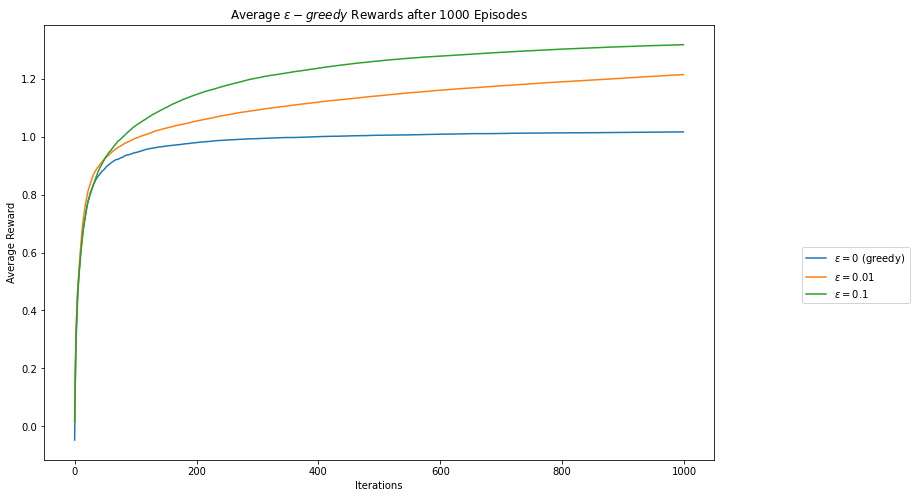

<IPython.core.display.Javascript object>

In [3]:
k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters)
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())

    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()

    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

plt.figure(figsize=(12, 8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

* greedy function underperforms the other two consistently, with $\epsilon=0.01$ coming in between the two and $\epsilon=0.1$ performing the best of the three

## Sequence vs Random means

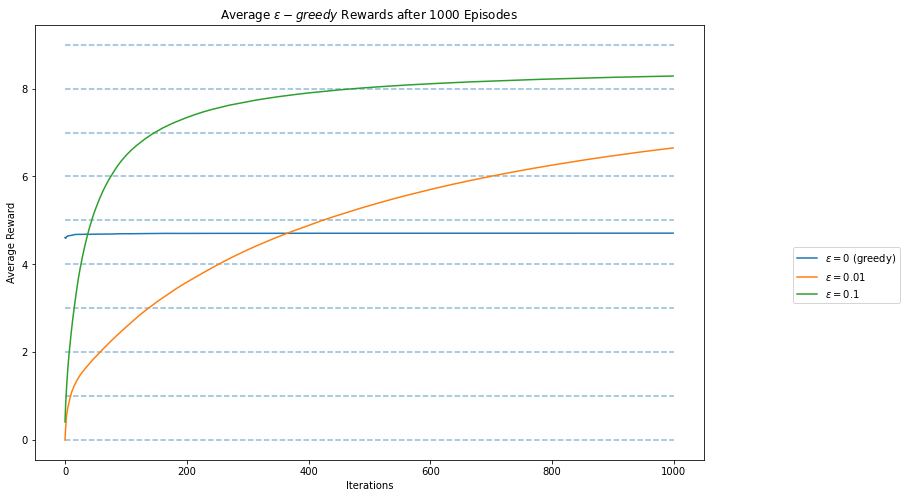

<IPython.core.display.Javascript object>

In [4]:
k = 10
iters = 1000

eps_0_rewards = np.zeros(iters)
eps_01_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)
eps_0_selection = np.zeros(k)
eps_01_selection = np.zeros(k)
eps_1_selection = np.zeros(k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_0 = eps_bandit(k, 0, iters, mu="sequence")
    eps_01 = eps_bandit(k, 0.01, iters, eps_0.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, eps_0.mu.copy())

    # Run experiments
    eps_0.run()
    eps_01.run()
    eps_1.run()

    # Update long-term averages
    eps_0_rewards = eps_0_rewards + (eps_0.reward - eps_0_rewards) / (i + 1)
    eps_01_rewards = eps_01_rewards + (eps_01.reward - eps_01_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

    # Average actions per episode
    eps_0_selection = eps_0_selection + (eps_0.k_n - eps_0_selection) / (i + 1)
    eps_01_selection = eps_01_selection + (eps_01.k_n - eps_01_selection) / (i + 1)
    eps_1_selection = eps_1_selection + (eps_1.k_n - eps_1_selection) / (i + 1)

plt.figure(figsize=(12, 8))
plt.plot(eps_0_rewards, label="$\epsilon=0$ (greedy)")
plt.plot(eps_01_rewards, label="$\epsilon=0.01$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
for i in range(k):
    plt.hlines(eps_0.mu[i], xmin=0, xmax=iters, alpha=0.5, linestyle="--")
plt.legend(bbox_to_anchor=(1.3, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-greedy$ Rewards after " + str(episodes) + " Episodes")
plt.show()

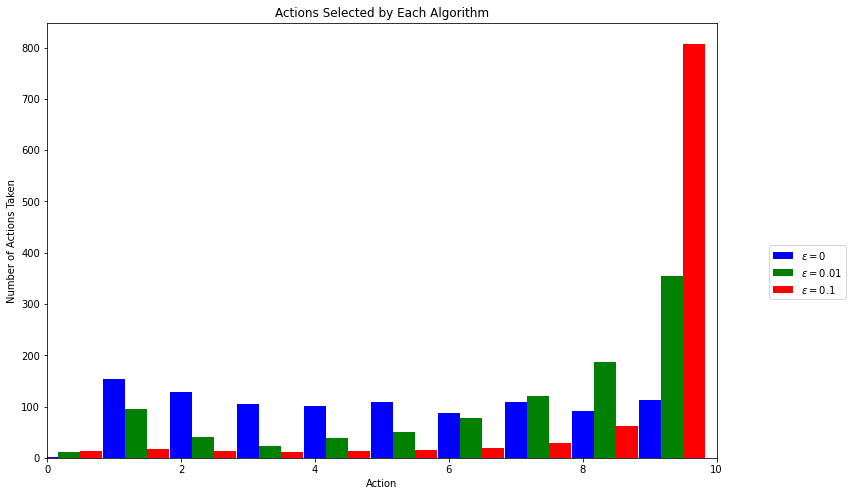

Percentage of actions selected:


,a = 0,a = 1,a = 2,a = 3,a = 4,a = 5,a = 6,a = 7,a = 8,a = 9
$\epsilon=0$,0.2147,15.3774,12.9079,10.4000,10.2000,10.8000,8.7000,10.90,9.2000,11.3000
$\epsilon=0.01$,1.1400,9.5421,4.0744,2.3920,3.8337,5.0452,7.7958,11.99,18.6387,35.5481
$\epsilon=0.1$,1.3229,1.7004,1.3112,1.1842,1.2774,1.4321,1.8216,2.90,6.2671,80.7831


<IPython.core.display.Javascript object>

In [5]:
bins = np.linspace(0, k - 1, k)

plt.figure(figsize=(12, 8))
plt.bar(bins, eps_0_selection, width=0.33, color="b", label="$\epsilon=0$")
plt.bar(bins + 0.33, eps_01_selection, width=0.33, color="g", label="$\epsilon=0.01$")
plt.bar(bins + 0.66, eps_1_selection, width=0.33, color="r", label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlim([0, k])
plt.title("Actions Selected by Each Algorithm")
plt.xlabel("Action")
plt.ylabel("Number of Actions Taken")
plt.show()

opt_per = np.array([eps_0_selection, eps_01_selection, eps_1_selection]) / iters * 100
df = pd.DataFrame(
    opt_per,
    index=["$\epsilon=0$", "$\epsilon=0.01$", "$\epsilon=0.1$"],
    columns=["a = " + str(x) for x in range(0, k)],
)
print("Percentage of actions selected:")
df

* decreasing the search space would likely benefit smaller values of $\epsilon$ as exploration would be less beneficial and vice versa. 
* increasing the number of iterations will begin to benefit the lower value of $\epsilon$ because it will have less random noise.

## $\epsilon$ Decay Bandit


* The $\epsilon$-greedy strategies have an obvious weakness in that they continue to include random noise no matter how many examples they see. 
* It would be better for these to settle on an optimal solution and continue to exploit it. 
* To this end, we can introduce $\epsilon$-decay which reduces the probability of exploration with every step.

In [6]:
class eps_decay_bandit:
    """
    epsilon-decay k-bandit problem

    Inputs
    =====================================================
    k: number of arms (int)
    iters: number of steps (int)
    mu: set the average rewards for each of the k-arms.
        Set to "random" for the rewards to be selected from
        a normal distribution with mean = 0.
        Set to "sequence" for the means to be ordered from
        0 to k-1.
        Pass a list or array of length = k for user-defined
        values.
    """

    def __init__(self, k, iters, mu="random"):
        # Number of arms
        self.k = k
        # Number of iterations
        self.iters = iters
        # Step count
        self.n = 0
        # Step count for each arm
        self.k_n = np.zeros(k)
        # Total mean reward
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        # Mean reward for each arm
        self.k_reward = np.zeros(k)

        if type(mu) == list or type(mu).__module__ == np.__name__:
            # User-defined averages
            self.mu = np.array(mu)
        elif mu == "random":
            # Draw means from probability distribution
            self.mu = np.random.normal(0, 1, k)
        elif mu == "sequence":
            # Increase the mean for each arm by one
            self.mu = np.linspace(0, k - 1, k)

    def pull(self):
        # Generate random number
        p = np.random.rand()
        if p < 1 / (1 + self.n / self.k):
            # Randomly select an action
            a = np.random.choice(self.k)
        else:
            # Take greedy action
            a = np.argmax(self.k_reward)

        reward = np.random.normal(self.mu[a], 1)

        # Update counts
        self.n += 1
        self.k_n[a] += 1

        # Update total
        self.mean_reward = self.mean_reward + (reward - self.mean_reward) / self.n

        # Update results for a_k
        self.k_reward[a] = self.k_reward[a] + (reward - self.k_reward[a]) / self.k_n[a]

    def run(self):
        for i in range(self.iters):
            self.pull()
            self.reward[i] = self.mean_reward

    def reset(self):
        # Resets results while keeping settings
        self.n = 0
        self.k_n = np.zeros(k)
        self.mean_reward = 0
        self.reward = np.zeros(iters)
        self.k_reward = np.zeros(k)

<IPython.core.display.Javascript object>

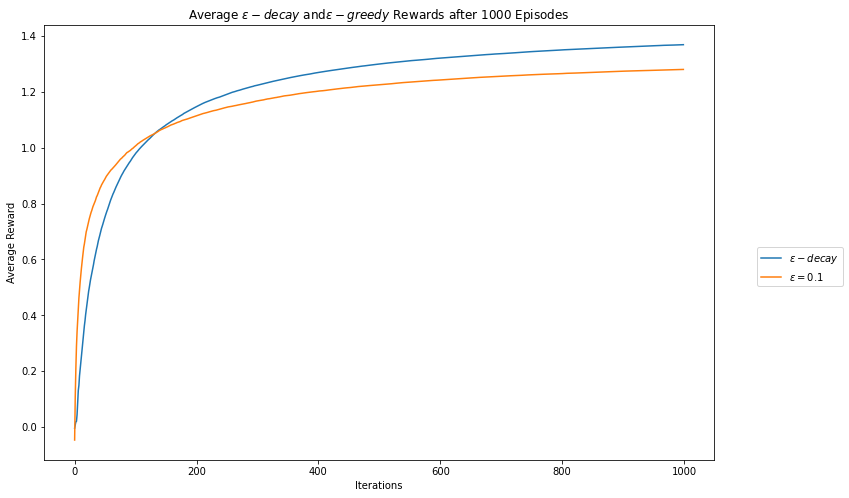

<IPython.core.display.Javascript object>

In [7]:
k = 10
iters = 1000

eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    eps_decay = eps_decay_bandit(k, iters)
    eps_1 = eps_bandit(k, 0.1, iters, eps_decay.mu.copy())
    
    # Run experiments
    eps_decay.run()
    eps_1.run()
    
    # Update long-term averages
    eps_decay_rewards = eps_decay_rewards + (
        eps_decay.reward - eps_decay_rewards) / (i + 1)
    eps_1_rewards = eps_1_rewards + (
        eps_1.reward - eps_1_rewards) / (i + 1)
    
plt.figure(figsize=(12,8))
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average $\epsilon-decay$ and" + 
    "$\epsilon-greedy$ Rewards after " 
    + str(episodes) + " Episodes")
plt.show()


## Optimistic Initial Value

*  Instead, we over estimate the rewards of all the actions and continuously select the maximium
*  the algorithm explores early on as it seeks to maximize its returns while additional information allows the values to converge to their true means. 
* This approach does require some additional background knowledge to be included in the set up because we need at least some idea of what the rewards are so that we can over estimate them.

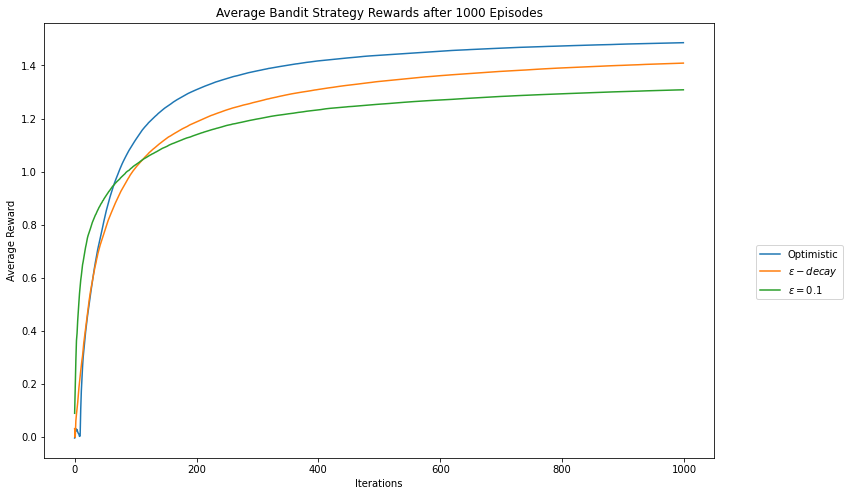

<IPython.core.display.Javascript object>

In [8]:
k = 10
iters = 1000

oiv_rewards = np.zeros(iters)
eps_decay_rewards = np.zeros(iters)
eps_1_rewards = np.zeros(iters)

# Select initial values
oiv_init = np.repeat(5.0, k)

episodes = 1000
# Run experiments
for i in range(episodes):
    # Initialize bandits
    oiv_bandit = eps_bandit(k, 0, iters)
    oiv_bandit.k_reward = oiv_init.copy()
    oiv_bandit.k_n = np.ones(k)
    eps_decay = eps_decay_bandit(k, iters, oiv_bandit.mu.copy())
    eps_1 = eps_bandit(k, 0.1, iters, oiv_bandit.mu.copy())

    # Run experiments
    oiv_bandit.run()
    eps_decay.run()
    eps_1.run()

    # Update long-term averages
    oiv_rewards = oiv_rewards + (oiv_bandit.reward - oiv_rewards) / (i + 1)
    eps_decay_rewards = eps_decay_rewards + (eps_decay.reward - eps_decay_rewards) / (
        i + 1
    )
    eps_1_rewards = eps_1_rewards + (eps_1.reward - eps_1_rewards) / (i + 1)

plt.figure(figsize=(12, 8))
plt.plot(oiv_rewards, label="Optimistic")
plt.plot(eps_decay_rewards, label="$\epsilon-decay$")
plt.plot(eps_1_rewards, label="$\epsilon=0.1$")
plt.legend(bbox_to_anchor=(1.2, 0.5))
plt.xlabel("Iterations")
plt.ylabel("Average Reward")
plt.title("Average Bandit Strategy Rewards after " + str(episodes) + " Episodes")
plt.show()

In [9]:
df = pd.DataFrame(
    {
        "number of selections": oiv_bandit.k_n - 1,
        "actual reward": oiv_bandit.mu,
        "estimated reward": oiv_bandit.k_reward,
    }
)
df = df.applymap(lambda x: np.round(x, 2))
df["number of selections"] = df["number of selections"].astype("int")
df

,number of selections,actual reward,estimated reward
0,3,0.48,0.74
1,3,-0.45,0.62
2,951,1.16,1.21
3,3,0.67,0.99
4,3,-0.08,1.01
5,28,1.00,1.17
6,1,-0.99,1.07
7,2,-0.83,0.46
8,4,-0.52,0.89
9,2,-0.62,0.60


<IPython.core.display.Javascript object>